# Image to MIDI and MIDI to image processing

This notebook contains tools to enable smoothing conversion between image (PNG) and MIDI files.

These tools were useful for creating a dataset to use with Nvidia's PGGAN.

## Constants and imports

In [103]:
import os

from PIL import Image
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

from utils import *

FS     = 16   # sample rate
LENGTH = 128  # number of timesteps in a sample

ModuleNotFoundError: No module named 'utils'

## MIDI to PNG

Convert midi files to images (PNG)

In [ ]:
def sample_to_img(sample, path):
    rescaled_sample = (255*sample).astype(np.uint8)
    im = Image.fromarray(rescaled_sample, 'L')
    im.save(path)


In [ ]:
DIRECTORY   = "zelda"  # directory with midi files. Change this to change dataset
VERBOSE     = True     # print extra info about each parsed file
NUM_SAMPLES = None     # restrict number of extracted samples

data = []
c_samples = 0
for filename in os.listdir(DIRECTORY):
    if filename.endswith(".mid"): 
        fn = os.path.join(directory, filename)
        try:
            midi_data = pretty_midi.PrettyMIDI(fn)
        except:
            continue
        mat = generate_combine_piano_roll(midi_data, FS)
        if mat is None:
            continue
        samples = split_sample(mat, LENGTH)
        filtered_samples = []
        for sample in samples:
            if np.count_nonzero(sample) > 0:
                filtered_samples.append(np.expand_dims(sample, axis=0))
        filtered_samples = np.vstack(filtered_samples)
        data.append(filtered_samples)
        c_samples += len(filtered_samples)
        if VERBOSE:
            print(len(filtered_samples), " samples from '", fn, "'")
        if NUM_SAMPLES and c_samples >= NUM_SAMPLES:
            break

data = np.vstack(data)
if NUM_SAMPLES:
    data = data[0:NUM_SAMPLES]

print("Data shape: ", data.shape)


In [43]:
for i, sample in enumerate(data):
    sample_to_img(sample.T, 'images/sample_%d.png' % i)

## Image to MIDI

The following code parses an image which contains a grid of samples with specifyable width and a height of 128 (required by the MIDI format).

If the image only contains a single sample, the width can be set to None (or the image size)

In [107]:
def image_to_midi(img_path, midi_path, width=None, binarize=True,
                  bottom_clip=5, top_clip=128, plot=True):
    """
        Converts an image with a grid of samples to corresponding midi files
    """
    im = Image.open(img_path)
    a = np.fromstring(im.tobytes(), dtype=np.uint8)
    a = a.reshape((im.size[1], im.size[0]))
    
    a[a<bottom_clip] = 0     # remove any notes with pixel value below bottom_clip
    
    if binarize:
        a[a>0] = 1
    else:
        a[a>top_clip] = top_clip # cap any notes with pixel values larger top_clip
        a = (a - a.min())/(a.max() - a.min())
    
    if plot:
        plt.figure(figsize=(20,20))
        plt.imshow(a, cmap="gray_r")
    
    if width is None:
        width = a.shape[1]
    height = 128 # this is required by the midi format

    for row in range(int(a.shape[0] / height)):
        for col in range(int(a.shape[1]/width)):
            frame = a[row*height:(row+1)*height,col*width:(col+1)*width]
            pm = piano_roll_to_pretty_midi(frame * 127, fs=16, program=0)
            pm.write("%s_%d_%d.mid" % (midi_path, row, col))


/Users/adam/.virtualenvs/deep-machine-learning-DDy5pt73/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


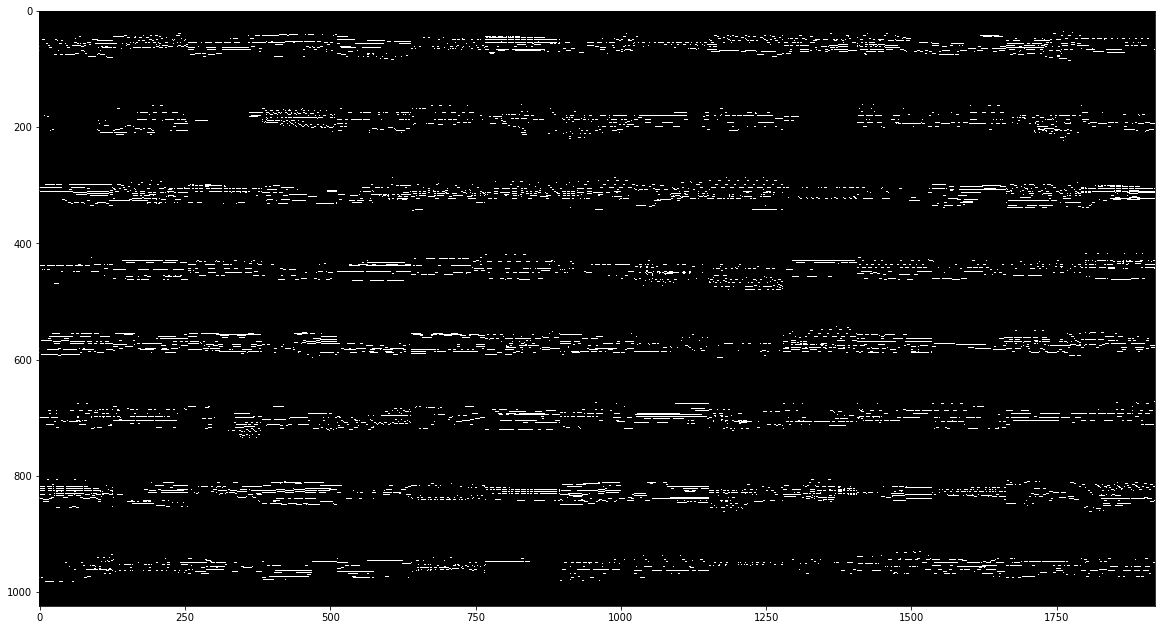

In [104]:
#convert all images to midi files
image_to_midi("gen_img_new/fakes001000.png", "gen/sample_frame", width=128, height=128)

## Training progress visualization

This script parses an image which contains a grid of samples from training. This format is specifically produced by Nvidia's PGGAN but can easily be adapted to 1x1 ''grids'' as well.

In [108]:
def extract_samples(img_path, n, height=128, width=128, offset=0):
    im = Image.open(img_path)
    a = np.fromstring(im.tobytes(), dtype=np.uint8)
    a = a.reshape((im.size[1], im.size[0]))

    if width is None:
        width = a.shape[1]

    frames = []
    i = 0
    for row in range(int(a.shape[0] / height)):
        for col in range(int(a.shape[1]/width)):
            if i < offset:
                continue
            frame = a[row*height:(row+1)*height,col*width:(col+1)*width]
            frames.append(frame/255)
            i+=1
            if i == n:
                return frames


def plot_row(data, nbr, n_rows, n_cols):
    for i in range(len(data)):
        idx = nbr * n_cols + i + 1
        ax = fig.add_subplot(n_rows, n_cols, idx)
        ax.matshow(data[i], aspect="auto", vmin=0, vmax=1, cmap="gray_r")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


/Users/adam/.virtualenvs/deep-machine-learning-DDy5pt73/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


15 predictions with shapes (128, 128)


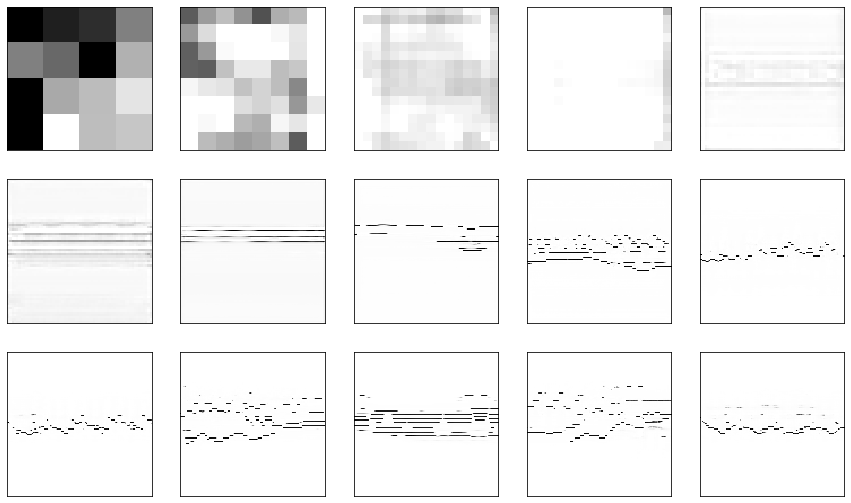

In [109]:
# Load the desired samples
samples = []

samples += extract_samples("gen_img_new/fakes000020.png", 1)
samples += extract_samples("gen_img_new/fakes000061.png", 1)
samples += extract_samples("gen_img_new/fakes000102.png", 1)
samples += extract_samples("gen_img_new/fakes000143.png", 1)
samples += extract_samples("gen_img_new/fakes000224.png", 1)

samples += extract_samples("gen_img_new/fakes000264.png", 1)
samples += extract_samples("gen_img_new/fakes000304.png", 1)
samples += extract_samples("gen_img_new/fakes000344.png", 1)
samples += extract_samples("gen_img_new/fakes000384.png", 1)
samples += extract_samples("gen_img_new/fakes000424.png", 1)

samples += extract_samples("gen_img_new/fakes000564.png", 5)


fig = plt.figure(figsize=(15, 9))
print(len(preds), "predictions with shapes", preds[0].shape)

plot_row(preds[0:5], 0, 3, 5)
plot_row(preds[5:10], 1, 3, 5)
plot_row(preds[10:15], 2, 3, 5)
